In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [2]:
wine_quality = fetch_ucirepo(id=186)

# Pre-processing
df = wine_quality.data.original


def categorize_quality(quality):
    if quality < 7:
        return 'bad'
    else:
        return 'good'


df['quality_category'] = df['quality'].apply(categorize_quality)

red = df[df['color'] == 'red']
white = df[df['color'] == 'white']

df_array = [red, white, df]
wine_names = ['red', 'white', 'red and white']

In [3]:
df_names = ['Red Wine', 'White Wine', 'Combined Wine']


def confusion_matrix_plot(y_test, y_pred, clf, model):
    # Create both normalized and raw confusion matrices
    cm_raw = confusion_matrix(y_test, y_pred)
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize by true class
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Raw counts confusion matrix
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=clf.classes_)
    disp1.plot(cmap=plt.cm.Blues, ax=ax1, values_format='d')
    ax1.set_title(f'Confusion Matrix (Raw Counts)\n{model.__class__.__name__}')
    
    # Normalized confusion matrix (shows percentages for each true class)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=clf.classes_)
    disp2.plot(cmap=plt.cm.Blues, ax=ax2, values_format='.2f')
    ax2.set_title(f'Confusion Matrix (Normalized)\n{model.__class__.__name__}')
    
    plt.tight_layout()
    plt.show()


def optimized_folds(model, X, y):
    best_score = 0
    best_folds = 0

    for folds in np.arange(2, 11):
        scores = cross_val_score(model, X, y, cv=folds, scoring='f1_macro')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_folds = folds

    print(f"Best Folds: {best_folds} | Best Score: {best_score}")
    return best_folds


def pr_curve(y_test, y_scores, model):
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label='good')
    
    # Calculate Average Precision (area under PR curve)
    ap_score = average_precision_score(y_test, y_scores, pos_label='good')
    
    # Calculate baseline (random classifier performance)
    baseline = len(y_test[y_test == 'good']) / len(y_test)
    
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {ap_score:.3f})')
    plt.axhline(y=baseline, color='red', linestyle='--', linewidth=1, 
                label=f'Random Baseline (AP = {baseline:.3f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve for {model.__class__.__name__}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add text box with key metrics
    textstr = f'Average Precision: {ap_score:.3f}\nBaseline: {baseline:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return ap_score


def get_probability_scores(model, X_test):
    if hasattr(model, 'predict_proba'):
        # For models that support probability prediction
        probabilities = model.predict_proba(X_test)
        # Find the index of 'good' class
        good_index = list(model.classes_).index('good')
        return probabilities[:, good_index]
    elif hasattr(model, 'decision_function'):
        # For models with decision function (like SVM without probability)
        return model.decision_function(X_test)
    else:
        # Fallback: use predicted class as binary score (not ideal for PR curve)
        predictions = model.predict(X_test)
        return (predictions == 'good').astype(int)

Processing Red Wine DataFrame
Best Folds: 4 | Best Score: 0.6756418248528234
              precision    recall  f1-score   support

         bad       0.88      0.98      0.93       273
        good       0.71      0.26      0.38        47

    accuracy                           0.88       320
   macro avg       0.80      0.62      0.65       320
weighted avg       0.86      0.88      0.85       320

Best Folds: 4 | Best Score: 0.6756418248528234
              precision    recall  f1-score   support

         bad       0.88      0.98      0.93       273
        good       0.71      0.26      0.38        47

    accuracy                           0.88       320
   macro avg       0.80      0.62      0.65       320
weighted avg       0.86      0.88      0.85       320



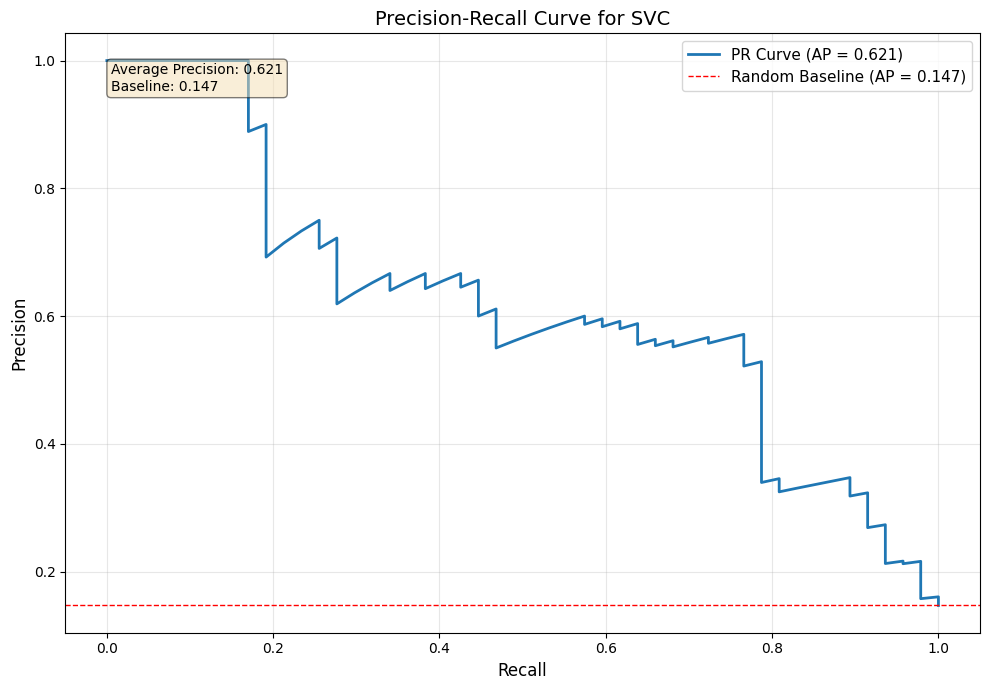

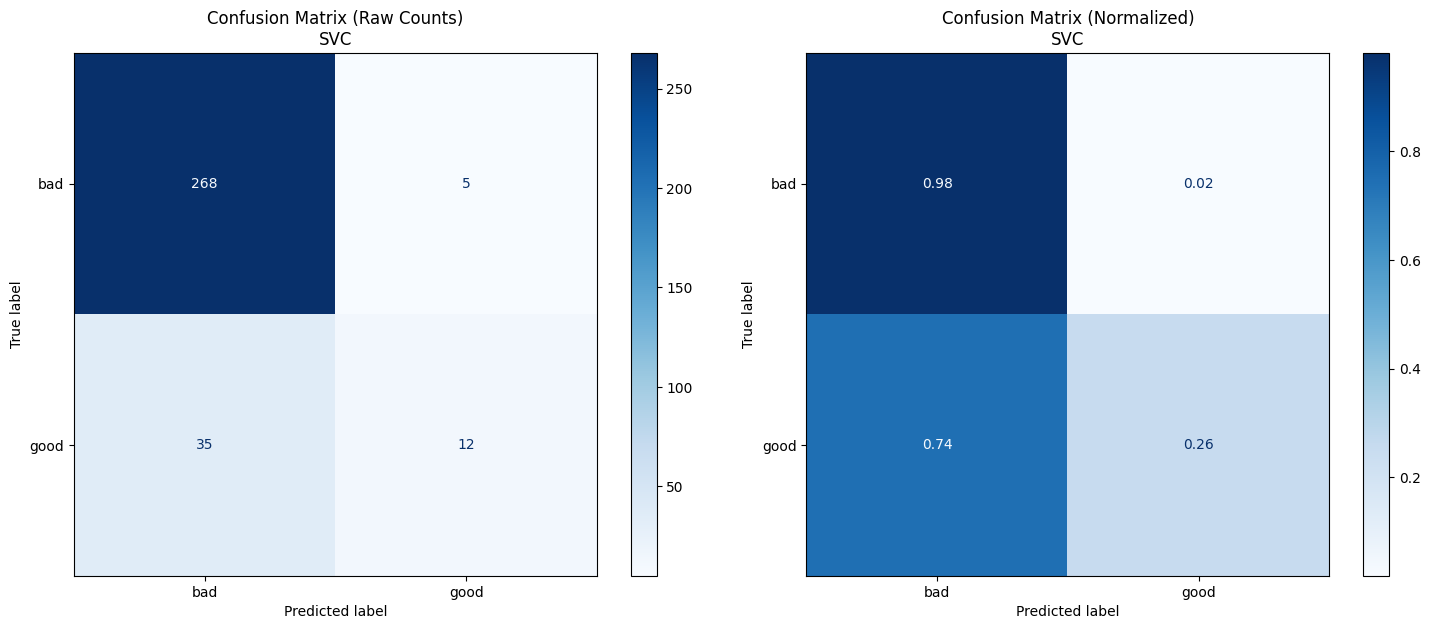



Processing White Wine DataFrame
Best Folds: 9 | Best Score: 0.6691323044434092
Best Folds: 9 | Best Score: 0.6691323044434092
              precision    recall  f1-score   support

         bad       0.83      0.97      0.89       753
        good       0.75      0.34      0.47       227

    accuracy                           0.82       980
   macro avg       0.79      0.65      0.68       980
weighted avg       0.81      0.82      0.79       980

              precision    recall  f1-score   support

         bad       0.83      0.97      0.89       753
        good       0.75      0.34      0.47       227

    accuracy                           0.82       980
   macro avg       0.79      0.65      0.68       980
weighted avg       0.81      0.82      0.79       980



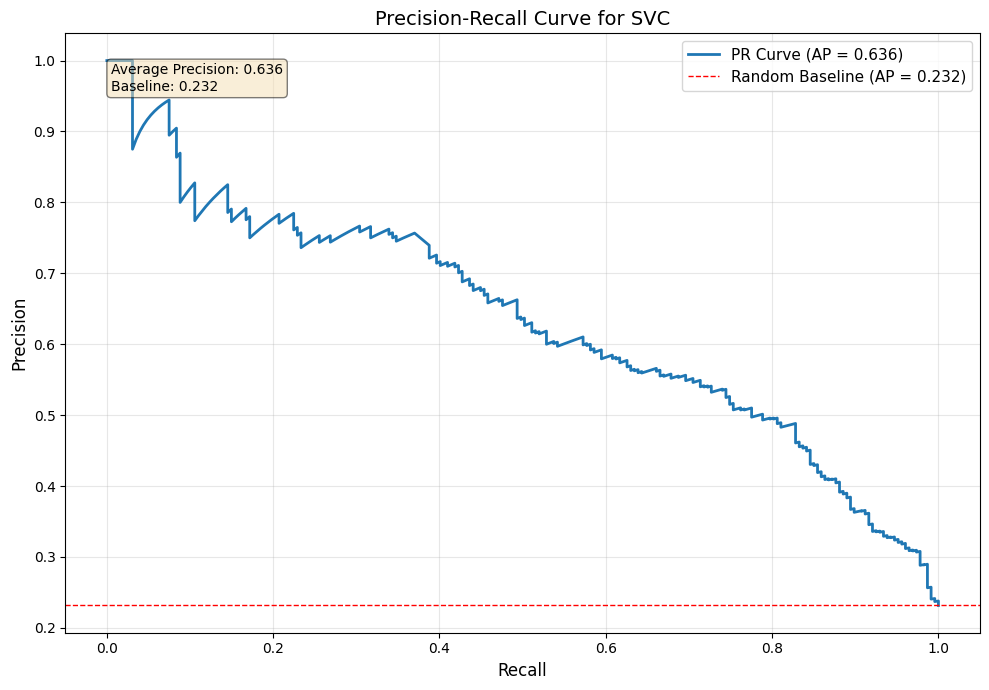

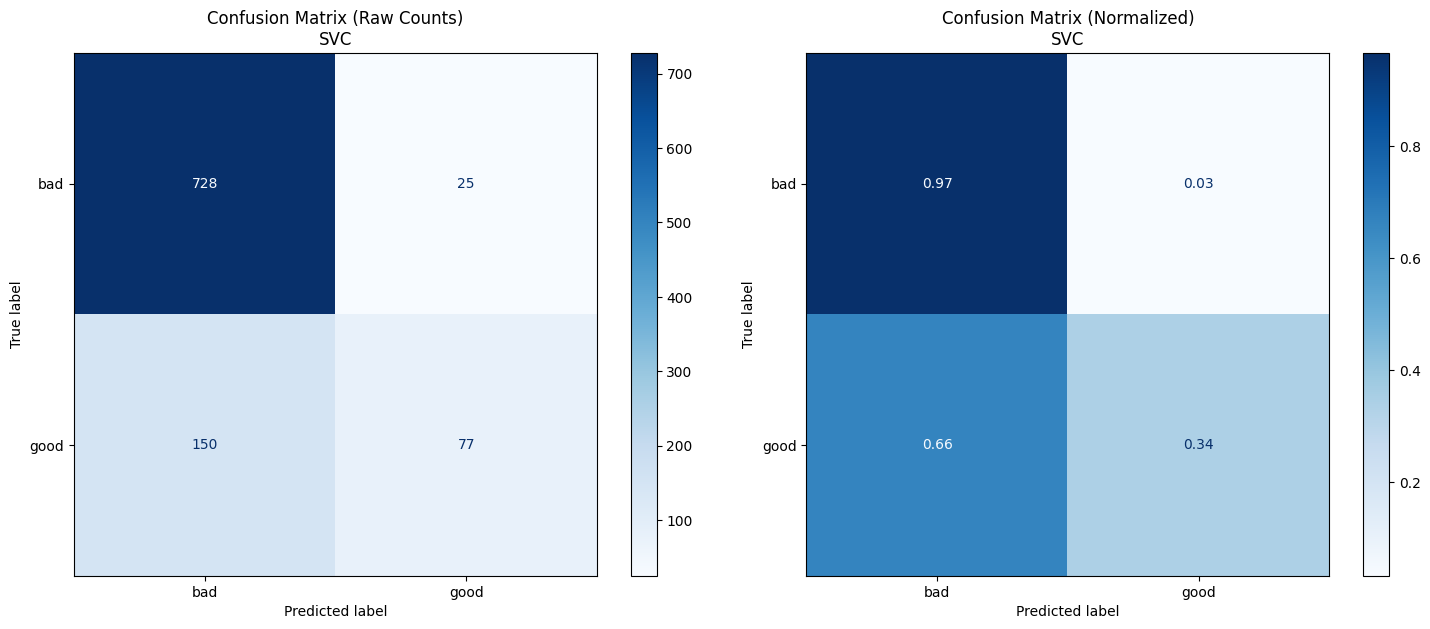



Processing Combined Wine DataFrame
Best Folds: 8 | Best Score: 0.6555323225153534
Best Folds: 8 | Best Score: 0.6555323225153534
              precision    recall  f1-score   support

         bad       0.85      0.97      0.91      1048
        good       0.71      0.27      0.39       252

    accuracy                           0.84      1300
   macro avg       0.78      0.62      0.65      1300
weighted avg       0.82      0.84      0.81      1300

              precision    recall  f1-score   support

         bad       0.85      0.97      0.91      1048
        good       0.71      0.27      0.39       252

    accuracy                           0.84      1300
   macro avg       0.78      0.62      0.65      1300
weighted avg       0.82      0.84      0.81      1300



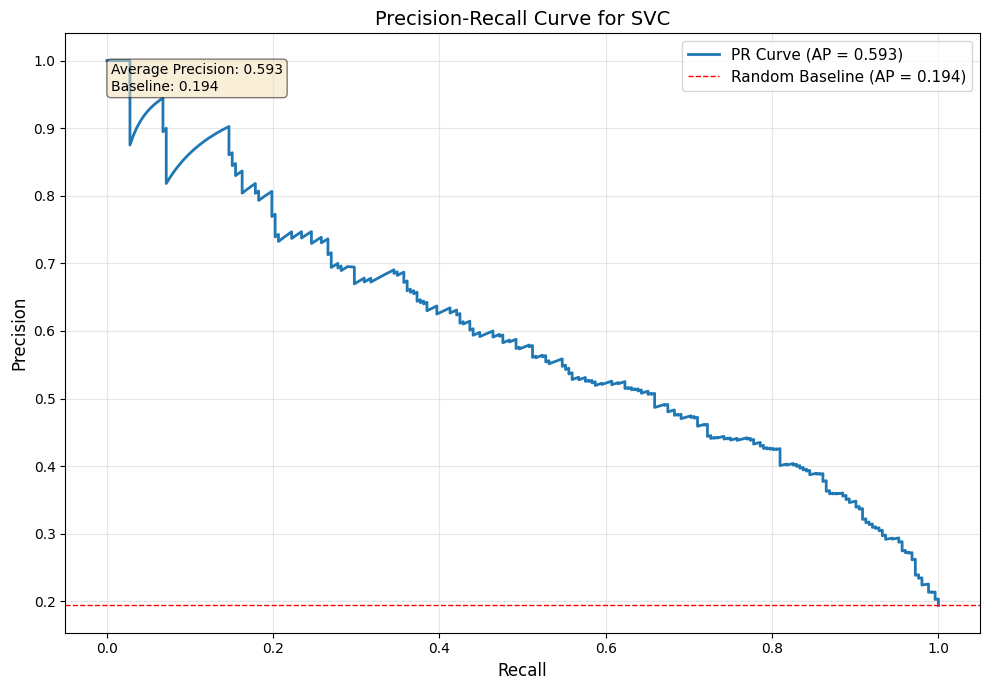

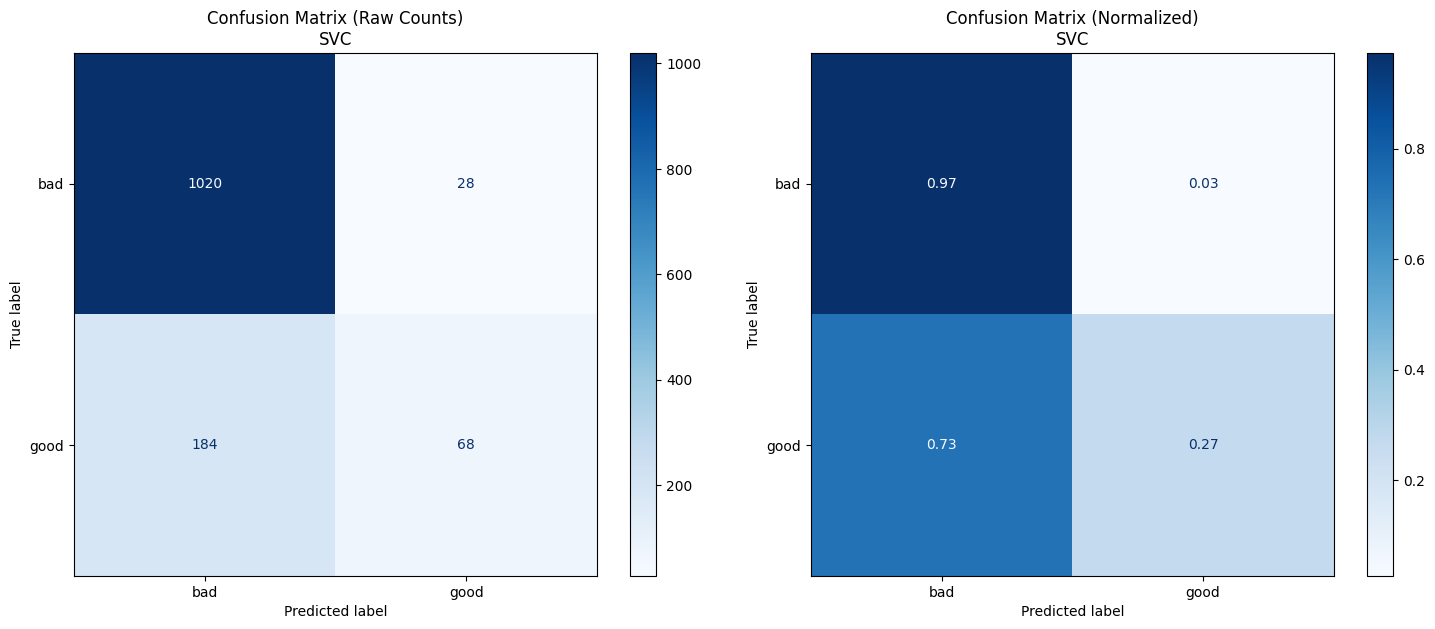

In [4]:
for i, wine in enumerate(df_array):
    print("=" * 40)
    print(f"Processing {df_names[i]} DataFrame")
    print("=" * 40)
    
    X = wine.drop(['quality', 'quality_category', 'color'], axis=1)
    y = wine['quality_category']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.2)

    # Enable probability estimates for ROC curve
    best_folds = optimized_folds(SVC(kernel='rbf', probability=True), X_train, y_train)
    svm = SVC(random_state=42, kernel='rbf', probability=True)
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    y_scores = get_probability_scores(svm, X_test)
    ap_score = pr_curve(y_test, y_scores, svm)

    confusion_matrix_plot(y_test, y_pred, svm, svm)
    print("\n")